In [17]:
%matplotlib inline

In [18]:
from __future__ import print_function

#Standard libraries
import sys
import time
import copy
import scipy
import numpy as np
import time

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

In [19]:
#ros messages
from std_msgs.msg import Float64MultiArray
from nav_msgs.msg import Path
from geometry_msgs.msg import PoseArray, Pose
from rss.msg import RssData, ProbArray

#Services
from rss.srv import Localization
from rss.localization_server import loc_server_handle, loc_server_client

#personal libraries
import GPy
from rss.classes import Measurement
from rss.classes import ProcessedData
from rss.load import load_data, load_model   

from Localization.sensormodel.gp import GP
from Localization.sensormodel.hybrid import hGP
from Localization.sensormodel.pathloss.classes_c import FLog

from util.others import mesh
from util.distance import euclidean_squared

from py_plot import *
from py_other import *

import itertools
from  tqdm import tqdm

In [20]:
def eprint(*args, **kwargs):                    #prints errors/warnings to stderr
    print(*args, file=sys.stderr, **kwargs)

In [21]:
import pandas as pd
import rosbag
from rf_sensor.msg import Rss
from geometry_msgs.msg import PoseWithCovarianceStamped
from nav_msgs.msg import Odometry

In [22]:
file_ = '/data/bags/tsukuba_challenge/09_14/paper01_gt.bag'
bag = rosbag.Bag(file_)

# Rss

In [23]:
# from rss definition
header_seq = list()
header_stamp_secs  = list()
header_stamp_nsecs = list()
header_frame_id = list()
mac_address = list()
freq = list()
data = list()

for topic, msg, t in bag.read_messages(topics=['rss',]):
    header_seq.append(msg.header.seq)
    header_stamp_secs.append(msg.header.stamp.secs)
    header_stamp_nsecs.append(msg.header.stamp.nsecs)
    header_frame_id.append(msg.header.frame_id)
    mac_address.append(msg.mac_address)
    freq.append(msg.freq)
    data.append((msg.data[0]+95)/95.) #as of now only using the first rss measurement
                             #to use all measurements maybe convert msg.data tuple to np array
                             #or create more indexes. The later sounds better

import pandas as pd
df_rss = pd.DataFrame.from_dict({
        'header_seq':header_seq,
        'header_stamp_secs':header_stamp_secs,
        'header_stamp_nsecs':header_stamp_nsecs,
        'header_frame_id':header_frame_id,
        'mac_address':mac_address,
        'freq':freq,
        'data':data    
        })

mac_address_unique = df_rss['mac_address'].unique().tolist()
mac_address_dict = {v:k for k,v in enumerate(mac_address_unique)}
print(len(mac_address_unique))

161


In [24]:
# breaks the dataframe into a list of dataframes grouped by time in seconds
delta_time = 5 # in seconds
# computing start and end times
start_time = np.min(df_rss['header_stamp_secs'])
end_time = np.max(df_rss['header_stamp_secs'])
time_ = np.arange(start_time,end_time,delta_time)
print('{:25s}: {:}-{:}'.format('time range',start_time,end_time))
# group dataframe items by time range and generating a list of dataframes per time range 
bins = pd.cut(df_rss['header_stamp_secs'],time_)
df_group = df_rss.groupby(bins)
df_rss_list = [group for name, group in df_group]
print('{:25s}: {:}'.format('Number of dataframes',len(df_rss_list)))

time range               : 1568443539-1568443937
Number of dataframes     : 79


In [25]:
#%%timeit
# get stats on the groups (rss mean, std and count)
df_rss_stats = [datum.groupby('mac_address').agg({'data':['mean','std','count']}) for datum in df_rss_list]

# filters
## min number of readings 
min_num_readings = 5
df_rss_stats_filtered = [df_[df_['data']['count']>=min_num_readings] for df_ in df_rss_stats]

In [26]:
# time required for stats and filtering ~ 322ms for 74 dataframes => ~4-5 ms per dataframe
#322/74.

In [27]:
print('============ Example data frame ============\n',df_rss_stats_filtered[0])

============ Example data frame ============
                        data                
                       mean       std count
mac_address                                
00:1d:93:6f:49:3c  0.159398  0.027653    14
00:26:73:d7:ef:67  0.372105  0.025734    40
6c:e4:da:9c:34:16  0.288158  0.032586    16
74:1b:b2:d6:9a:2a  0.087719  0.005436     6
80:fb:06:fa:52:d4  0.186842  0.016644     8
88:07:4b:9f:77:71  0.242105  0.032885    26
88:d7:f6:9f:40:80  0.168421  0.034305    30
a0:c5:89:47:92:49  0.194332  0.036855    26
c2:25:a2:3c:39:8e  0.163158  0.015221    12
c8:14:51:f4:7a:cf  0.476842  0.098694    40
c8:14:51:f4:7a:d4  0.278947  0.047528    32
e0:cb:bc:88:05:ad  0.066667  0.019599     6
e0:cb:bc:88:06:0f  0.084211  0.032615     6
f2:cb:bc:88:06:0f  0.078947  0.016880     8


In [28]:
# get Z matrix for GPs from filtered_stats
Z = list()
for datum in df_rss_stats:
    z_ = np.zeros(len(mac_address_dict))
    #get index from mac_address_dict and assign rss mean
    for mac_, row_ in datum.iterrows():
        z_[mac_address_dict[mac_]] = row_['data']['mean']
    Z.append(z_)
Z = np.asarray(Z)
print(Z.shape)

#TODO: check if a mac got completely filtered
#del_index = np.where(np.max(Z,axis=0)==0)
#del_index

(79, 161)


# Pose

In [29]:
# from rss definition
header_stamp_secs  = list()
header_stamp_nsecs = list()
pose_pose_position_x = list()
pose_pose_position_y = list()
#pose_pose_orientation = list()
pose_covariance = list()

for topic, msg, t in bag.read_messages(topics=['amcl_pose',]):
    header_stamp_secs.append(msg.header.stamp.secs)
    header_stamp_nsecs.append(msg.header.stamp.nsecs)
    pose_pose_position_x.append(msg.pose.pose.position.x)
    pose_pose_position_y.append(msg.pose.pose.position.y)

header_stamp_secs = np.asarray(header_stamp_secs)
header_stamp_nsecs = np.asarray(header_stamp_nsecs)
pose_pose_position_x = np.asarray(pose_pose_position_x)
pose_pose_position_y = np.asarray(pose_pose_position_y)

In [30]:
X = np.zeros((len(time_)-1,2))
time_offset = np.min(time_)
t1 = (time_-time_offset+delta_time/2)[:-1]
t2 = header_stamp_secs-time_offset+header_stamp_secs/1e9
X[:,0] = np.interp(t1,t2,pose_pose_position_x)
X[:,1] = np.interp(t1,t2,pose_pose_position_y)
#X+=np.random.normal(scale=0.1,size=X.shape)

In [31]:
# instead of rss.classes import ProcessedData
class ProcessedData():
    def __init__(self,X,Z,mac_address_dict):
        self.data = {'X':X, 'Y':Z, 'Var':Z}
        self.nm = X.shape[0]
        self.all_mac_dict = mac_address_dict

In [32]:
traindata = ProcessedData(X,Z,mac_address_dict)

In [33]:
import GPy
from Localization.sensormodel.gp import GP

In [34]:
Xtest_num = 100 #default: 50
Xtest_factor = .5 # default: .25

### Train model
print('Training GP')
model = GP(traindata.data,all_mac_dict=mac_address_dict,
        Xtest_num=Xtest_num,
        Xtest_factor=Xtest_factor)
model.optimize()
print(model)

time.sleep(1)
print('')

print('Number of measurements:        \t: ', traindata.nm)
print('Number of macs considered (all)\t: ', traindata.data['Y'].shape[1])

Training GP
Name                                : WGP
data
  X                                 : [  79,   2]
  Y                                 : [  79, 161]
  Var                               : [  79, 161]

Gaussian Process
  Name : GP regression
  Objective : -24529.5524249
  Number of Parameters : 3
  Number of Optimization Parameters : 3
  Updates : True
  Parameters:
    GP_regression.           |                  value  |  constraints  |  priors
    rbf.variance             |   0.003379815936119701  |      +ve      |        
    rbf.lengthscale          |     28.984947687725846  |      +ve      |        
    Gaussian_noise.variance  |  0.0009029693346553345  |      +ve      |        

Number of measurements:        	:  79
Number of macs considered (all)	:  161


(array([1.1095e+04, 1.0430e+03, 3.9900e+02, 1.2700e+02, 4.2000e+01,
        1.0000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.03536523, 0.07073045, 0.10609568, 0.14146091,
        0.17682613, 0.21219136, 0.24755659, 0.28292182, 0.31828704,
        0.35365227]),
 <a list of 10 Patch objects>)

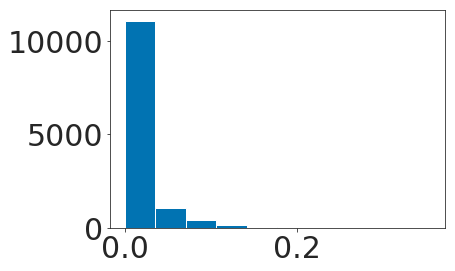

In [35]:
Zp,Vp = model.predict(X)
er = np.abs(Zp-Z)
plt.hist(er.flatten())

In [36]:
AP = 33#22#13#123

#predictions using all ap
Xtest = model.Xtest #traindata.data['X']
#Yg,Vg = g.predict(Xtest)#,flag_gp=True) #predicted_mean, predicted_variance
Yh,Vh = model.predict(Xtest)#,flag_gp=True) #predicted_mean, predicted_variance

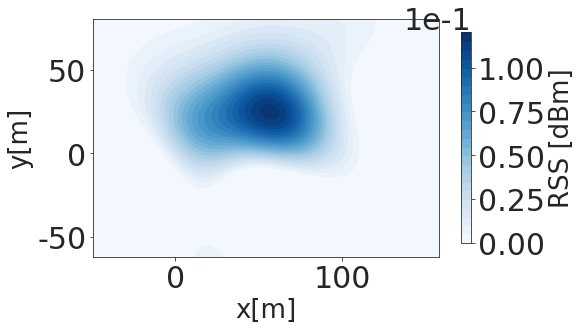

<Figure size 432x288 with 0 Axes>

In [37]:
Xtest = model.Xtest #traindata.data['X']
Yh,Vh = model.predict(Xtest)#,flag_gp=True) #predicted_mean, predicted_variance

for AP in (4,):
    cs_levels = 25#np.arange(-95,max_y,1)
    Y=Yh[:,[AP]]

    f,ax = plot_contour(Xtest,Y,v=cs_levels, kwargs_cbar={'label':'RSS [dBm]'})
    #ax.contour(cs,levels=cs.levels[1:][::3], colors='k',linestyles='solid',linewidths=1.)
    
    ax.set_xlabel('x[m]',fontsize=26)
    ax.set_xlim(np.min(Xtest[:,0]),np.max(Xtest[:,0]))
    ax.set_ylabel('y[m]',fontsize=26)
    ax.set_ylim(np.min(Xtest[:,1]),np.max(Xtest[:,1]))
    ax.set_aspect('equal')
    plt.tight_layout()

[WARN] could not load cupy. No gpu support
No dNN support


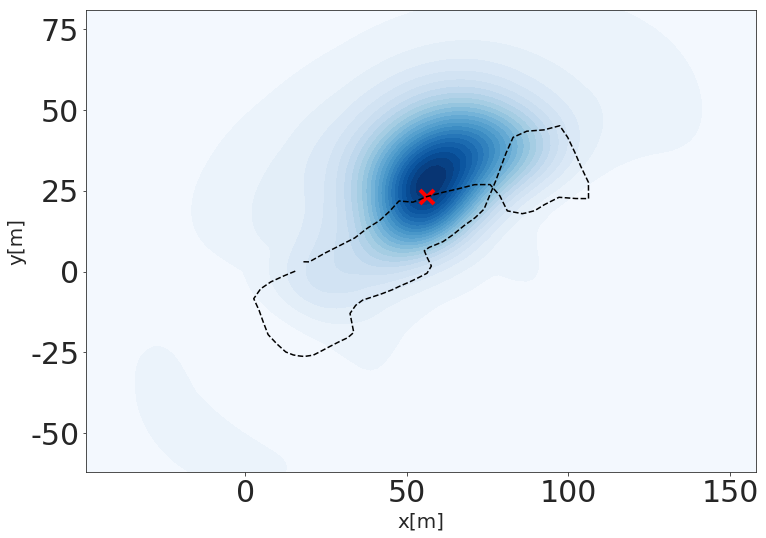

In [38]:
# Example without sampling
#sample using accept-reject
#very slow, but unbiased sampler
from Localization.sampling.sampling import accept_reject_uniform as sample
from Localization.sampling.sampling import accept_reject_by_regions as sample_original #original higher efficiency algorithm
from Localization.sensormodel._likelihoods.gPoE import gPoEMetric

h = model
h.likelihood = gPoEMetric(metric_fun='measurement')
h.sampling = sample

#predictions using WGPPL
TestPoint = 10

Xtest   = h.Xtest
shape = (100,100)


#WPPL prob
pXh = h.likelihood.jointpdf(h,Xtest,traindata.data['Y'][[TestPoint],:])

m_max = np.max(pXh)
v = np.linspace(0,m_max,25)

#Ploting
f,ax = plt.subplots(figsize=(12,9))
axis_lim = (h.xmin,h.xmax,h.ymin,h.ymax)
C = ax.contourf(np.reshape(Xtest[:,0],shape),np.reshape(Xtest[:,1],shape),np.reshape(pXh,shape),v,cmap='Blues')
ax.plot(traindata.data['X'][TestPoint,0],traindata.data['X'][TestPoint,1],'rx', markersize=14, markeredgewidth=4)
ax.axis(axis_lim)
ax.set_aspect('equal')
ax.set_xlabel('x[m]',fontsize=20)
ax.set_ylabel('y[m]',fontsize=20)
ax.plot(traindata.data['X'][:,0],traindata.data['X'][:,1],'--k')

plt.show()
#f.savefig('/data/posterior_example.eps')
#f.savefig('/data/posterior_example.jpg')